## GAN
Generative Adversarial Network

In [24]:
import random
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(color_codes=True)

### Real (R) world data

The original, genuine data set which G tried to mimic.

In our case, we’ll start with the simplest possible R — a bell curve. This function takes a mean and a standard deviation and returns a function which provides the right shape of sample data from a Gaussian with those parameters.

In [2]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))

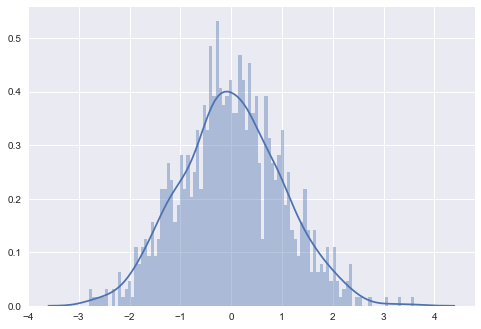

In [23]:
data = get_distribution_sampler(0, 1)(1000).numpy()
sns.distplot(data, bins=100)

### Input (I) to generator
This is the random noise that goes into the generator as a source of entropy.

The input into the generator is also random, but to make our job a little bit harder, let’s use a uniform distribution rather than a normal one. This means that our model G can’t simply shift/scale the input to copy R, but has to reshape the data in a non-linear way.

In [4]:
def get_generator_input_sampler():
    return lambda n, m: torch.rand(n, m)

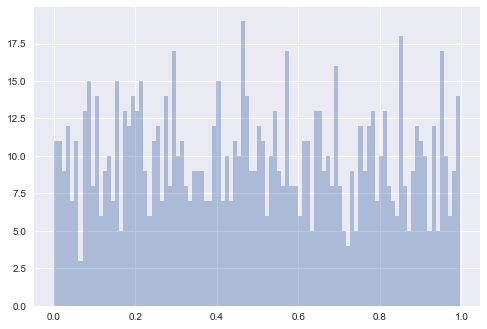

In [20]:
data = get_generator_input_sampler()(1, 1000).numpy()
sns.distplot(data, bins=100, kde=False)

### Generator

The generator is a standard feedforward graph — two hidden layers, three linear maps. We’re using an ELU (exponential linear unit). G is going to get the uniformly distributed data samples from I and somehow mimic the normally distributed samples from R.

In [6]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

### Discriminator

The discriminator code is very similar to G’s generator code; a feedforward graph with two hidden layers and three linear maps. It’s going to get samples from either R or G and will output a single scalar between 0 and 1, interpreted as ‘fake’ vs. ‘real’. This is about as milquetoast as a neural net can get.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [8]:
D = Discriminator(1, 10, 2)
D

Discriminator (
  (fc1): Linear (1 -> 10)
  (fc2): Linear (10 -> 10)
  (fc3): Linear (10 -> 2)
)